# 12년 데이터 학습(정방향)

In [1]:
!pip install tf-nightly

     |████████████████████████████████| 395.8MB 43kB/s 
     |████████████████████████████████| 10.6MB 53.3MB/s 
     |████████████████████████████████| 14.5MB 237kB/s 
     |████████████████████████████████| 1.3MB 52.2MB/s 
     |████████████████████████████████| 471kB 51.9MB/s 
     |████████████████████████████████| 3.8MB 52.0MB/s 
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Found existing installation: grpcio 1.33.2
    Uninstalling grpcio-1.33.2:
      Successfully uninstalled grpcio-1.33.2
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4

In [2]:
import tensorflow as tf
import tensorflow.keras.layers
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Nadam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


train data % : 50.79 test data % : 15.959999999999999
Epoch 1/500
32/32 [==============================] - 10s 161ms/step - loss: 0.7399 - accuracy: 0.4900 - val_loss: 0.7276 - val_accuracy: 0.1627

Epoch 00001: val_loss improved from inf to 0.72761, saving model to /content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5
Epoch 2/500
32/32 [==============================] - 4s 137ms/step - loss: 0.7071 - accuracy: 0.4996 - val_loss: 0.7141 - val_accuracy: 0.1627

Epoch 00002: val_loss improved from 0.72761 to 0.71407, saving model to /content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5
Epoch 3/500
32/32 [==============================] - 4s 130ms/step - loss: 0.6952 - accuracy: 0.5238 - val_loss: 0.6806 - val_accuracy: 0.8373

Epoch 00003: val_loss improved from 0.71407 to 0.68059, saving model to /content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5
Epoch 4/500
32/32 [==============================] - 4s 131ms/step - loss: 0.6830 - accuracy: 0.5829 - val_loss: 0.615

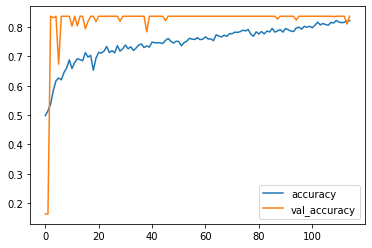

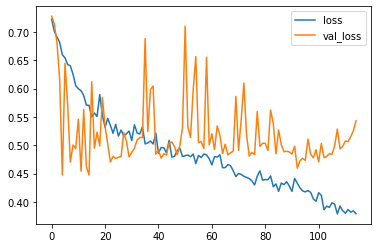

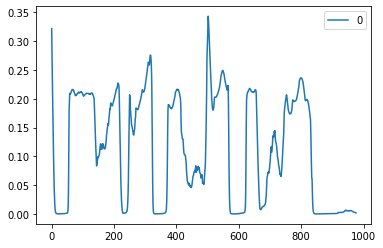

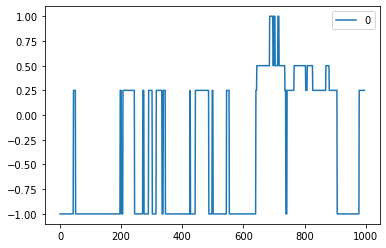

In [ ]:
# 데이터 셋 불러오기
df = pd.read_csv("/content/gdrive/My Drive/SBUX_rev.2.csv")

# column name 재정의
df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

# stock data & gold data 로짓
df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

# 수정종가와 종가의 차이를 기반으로, 배당 등의 기업 재무 이벤트 반영 변수 gap 생성
df['gap'] = df['adj']/df['close'] 

# 목표로 하는 수익율을 구간 기반으로 함으로써 예측
df['mov5'] = df['adj'].rolling(5).mean()

# 오늘의 5이평과 미래의 5이평을 기준으로 타겟 변수인 수익율 변수 생성
df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1w'] = (df['mov5'].shift(-5) - df['mov5'])/df['mov5']
df['2w'] = (df['mov5'].shift(-10) - df['mov5'])/df['mov5']
df['4w'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['6w'] = (df['mov5'].shift(-30) - df['mov5'])/df['mov5']
df['8w'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['10w'] = (df['mov5'].shift(-50) - df['mov5'])/df['mov5']
df['12w'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['18w'] = (df['mov5'].shift(-90) - df['mov5'])/df['mov5']
df['24w'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5']

# 총 11개의 수익 구간 중에서 현실적으로 이익을 얻을 수 있는 3, 4, 5위의 평균을 현실적인 수익율로 지정
df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

# 변수를 생성하는 과정에서 생겨난 nan 열들을 제거
df = df.dropna(axis=0)

df['return'].describe()

# 수익율을 다시 구간화
def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1              # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2              # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3              # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

# 모델의 val_loss 값을 기준으로 가장 최선의 모델을 stock_01에 저장
from tensorflow.keras.callbacks import ModelCheckpoint

modelpath = "/content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5"
checkpointer = ModelCheckpoint(filepath = modelpath, monitor = 'val_loss', verbose = 1, save_best_only = True)

# 모델의 val_loss 값을 기준으로 개선되지 않는 것이 100회 이상 누적되면 epoch 종료
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 100)

# 독립변수와 종속 변수 지정
input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

# 한 번에 분석할 기간의 수 및 차원 지정
T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GRU

# EnSemble : 12년치 데이터이기 때문에 세 개의 모델을 앙상블하고 보다 많은 output을 내도록 구성

i = Input(shape=(T,D))

# 과대적합과 모델이 빠르게 식상해지는 것을 방지하기 위해 dropout option 추가
lstm = LSTM(128, dropout=0.2, recurrent_dropout=0.2)
left_input = Input(shape=(T,D))
left_output = lstm(left_input)

rnn = SimpleRNN(128, dropout = 0.2, recurrent_dropout = 0.2)
middle_input = i
middle_output = rnn(middle_input)

gru = GRU(128,  dropout=0.2, recurrent_dropout=0.2)
right_input = Input(shape= (T,D))
right_output = gru(right_input)

# merge
merged = tf.keras.layers.concatenate([left_output,middle_output, right_output], axis = -1)
merged = Dropout(rate=0.7)(merged)
merged = Dense(256, activation='relu')(merged)
merged = Dropout(rate=0.7)(merged)
merged = Dense(5, LeakyReLU(alpha=0.1))(merged)
predictions = tf.keras.layers.Dense(1, activation = 'sigmoid')(merged)


model = Model([left_input,middle_input, right_input], predictions)

# 대용량 데이터이기 때문에 학습율을 0.0005로 낮게 잡음
# 데이터의 속성을 제일 잘 반영할 수 있는 Nadam을 optimizer로 선택
model.compile(
    loss = 'binary_crossentropy',
    sample_weight_mode = 'temporal',
    optimizer = Nadam(lr = 0.0005),
    metrics = ['accuracy'],
)

# 모델 객체 만들고 훈련
r = model.fit([X_train, X_train, X_train], 
          Y_train,
          batch_size = 64,
          epochs = 500,
          validation_data = ([X_test, X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

# 모델의 정확도와 로스 측정
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_test,X_test, X_test])).plot()
pd.DataFrame(target[Ntrain:]).plot()

train data % : 26.72 test data % : 12.83
Epoch 1/500
32/32 [==============================] - 8s 155ms/step - loss: 0.5874 - accuracy: 0.7633 - val_loss: 0.4492 - val_accuracy: 0.8691

Epoch 00001: val_loss improved from inf to 0.44923, saving model to /content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5
Epoch 2/500
32/32 [==============================] - 4s 139ms/step - loss: 0.5623 - accuracy: 0.7713 - val_loss: 0.4809 - val_accuracy: 0.8691

Epoch 00002: val_loss did not improve from 0.44923
Epoch 3/500
32/32 [==============================] - 4s 137ms/step - loss: 0.5523 - accuracy: 0.7693 - val_loss: 0.4473 - val_accuracy: 0.8691

Epoch 00003: val_loss improved from 0.44923 to 0.44734, saving model to /content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5
Epoch 4/500
32/32 [==============================] - 4s 136ms/step - loss: 0.5317 - accuracy: 0.7758 - val_loss: 0.5018 - val_accuracy: 0.8650

Epoch 00004: val_loss did not improve from 0.44734
Epoch 5/500
32/32 [

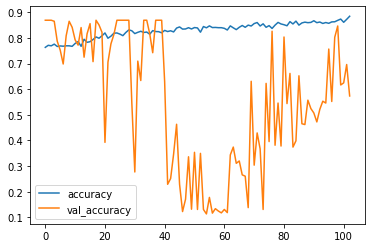

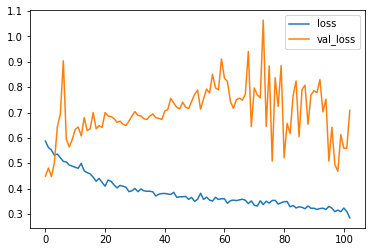

예측 결과 : 365.36548
실제 결과: 128.0
학습된 모델은 미래를 185.44 % 낙관적으로 전망하고 있습니다.


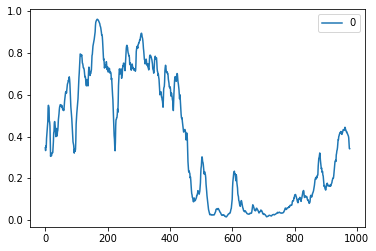

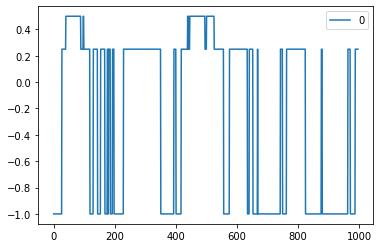

In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/AMZN.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1w'] = (df['mov5'].shift(-5) - df['mov5'])/df['mov5']
df['2w'] = (df['mov5'].shift(-10) - df['mov5'])/df['mov5']
df['4w'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['6w'] = (df['mov5'].shift(-30) - df['mov5'])/df['mov5']
df['8w'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['10w'] = (df['mov5'].shift(-50) - df['mov5'])/df['mov5']
df['12w'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['18w'] = (df['mov5'].shift(-90) - df['mov5'])/df['mov5']
df['24w'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5']

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df = df.dropna(axis=0)

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1              # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2              # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3              # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

from tensorflow.keras.callbacks import ModelCheckpoint

modelpath = "/content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5"
checkpointer = ModelCheckpoint(filepath = modelpath, monitor = 'val_loss', verbose = 1, save_best_only = True)

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 100)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5")

# 모델 객체 만들고 훈련


r = model.fit([X_train, X_train, X_train], 
          Y_train,
          batch_size = 64,
          epochs = 500,
          validation_data = ([X_test, X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_test,X_test, X_test])).plot()
pd.DataFrame(target[Ntrain:]).plot()


train data % : 48.96 test data % : 34.760000000000005
Epoch 1/500
25/25 [==============================] - 7s 163ms/step - loss: 0.6379 - accuracy: 0.6681 - val_loss: 0.6338 - val_accuracy: 0.6554

Epoch 00001: val_loss improved from inf to 0.63379, saving model to /content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5
Epoch 2/500
25/25 [==============================] - 3s 138ms/step - loss: 0.6116 - accuracy: 0.6694 - val_loss: 0.6252 - val_accuracy: 0.6567

Epoch 00002: val_loss improved from 0.63379 to 0.62517, saving model to /content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5
Epoch 3/500
25/25 [==============================] - 3s 138ms/step - loss: 0.5999 - accuracy: 0.6707 - val_loss: 0.5991 - val_accuracy: 0.7100

Epoch 00003: val_loss improved from 0.62517 to 0.59914, saving model to /content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5
Epoch 4/500
25/25 [==============================] - 3s 140ms/step - loss: 0.5994 - accuracy: 0.6770 - val_loss: 0.5747

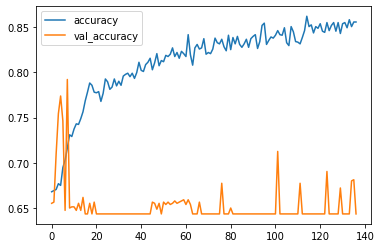

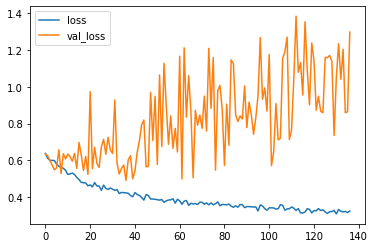

예측 결과 : 24.45373
실제 결과: 274.0
학습된 모델은 미래를 91.08000000000001 %  비관적으로 전망하고 있습니다.


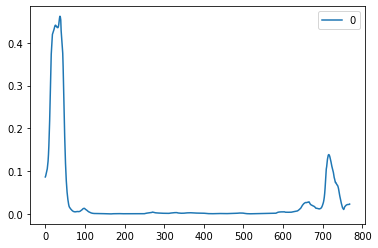

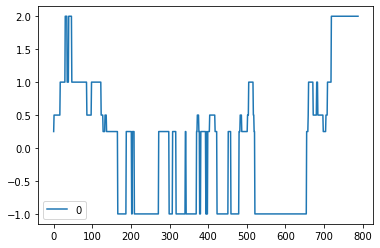

In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/TSLA.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1w'] = (df['mov5'].shift(-5) - df['mov5'])/df['mov5']
df['2w'] = (df['mov5'].shift(-10) - df['mov5'])/df['mov5']
df['4w'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['6w'] = (df['mov5'].shift(-30) - df['mov5'])/df['mov5']
df['8w'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['10w'] = (df['mov5'].shift(-50) - df['mov5'])/df['mov5']
df['12w'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['18w'] = (df['mov5'].shift(-90) - df['mov5'])/df['mov5']
df['24w'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5']

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df = df.dropna(axis=0)

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1              # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2              # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3              # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

from tensorflow.keras.callbacks import ModelCheckpoint

modelpath = "/content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5"
checkpointer = ModelCheckpoint(filepath = modelpath, monitor = 'val_loss', verbose = 1, save_best_only = True)

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 100)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5")

# 모델 객체 만들고 훈련

r = model.fit([X_train, X_train, X_train], 
          Y_train,
          batch_size = 64,
          epochs = 500,
          validation_data = ([X_test, X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_test,X_test, X_test])).plot()
pd.DataFrame(target[Ntrain:]).plot()


train data % : 54.75 test data % : 42.809999999999995
Epoch 1/500
32/32 [==============================] - 8s 155ms/step - loss: 0.6696 - accuracy: 0.6605 - val_loss: 0.9801 - val_accuracy: 0.5634

Epoch 00001: val_loss improved from inf to 0.98008, saving model to /content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5
Epoch 2/500
32/32 [==============================] - 4s 137ms/step - loss: 0.5964 - accuracy: 0.6765 - val_loss: 0.8643 - val_accuracy: 0.5838

Epoch 00002: val_loss improved from 0.98008 to 0.86430, saving model to /content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5
Epoch 3/500
32/32 [==============================] - 4s 137ms/step - loss: 0.5742 - accuracy: 0.7041 - val_loss: 1.0474 - val_accuracy: 0.5634

Epoch 00003: val_loss did not improve from 0.86430
Epoch 4/500
32/32 [==============================] - 4s 136ms/step - loss: 0.5406 - accuracy: 0.7172 - val_loss: 1.2151 - val_accuracy: 0.5634

Epoch 00004: val_loss did not improve from 0.86430
Epoch 

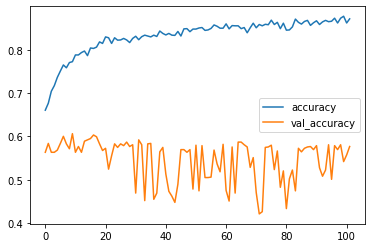

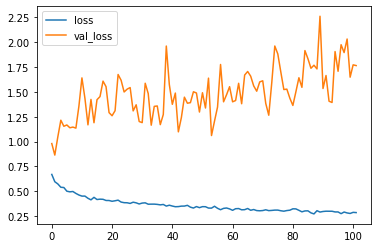

예측 결과 : 181.46184
실제 결과: 427.0
학습된 모델은 미래를 57.49999999999999 %  비관적으로 전망하고 있습니다.


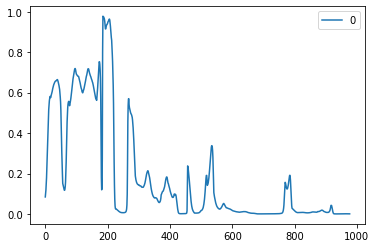

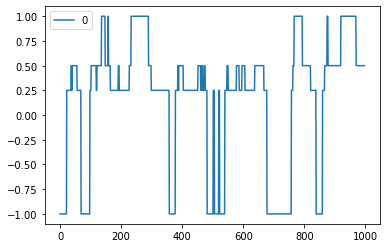

In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/AAPL.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1w'] = (df['mov5'].shift(-5) - df['mov5'])/df['mov5']
df['2w'] = (df['mov5'].shift(-10) - df['mov5'])/df['mov5']
df['4w'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['6w'] = (df['mov5'].shift(-30) - df['mov5'])/df['mov5']
df['8w'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['10w'] = (df['mov5'].shift(-50) - df['mov5'])/df['mov5']
df['12w'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['18w'] = (df['mov5'].shift(-90) - df['mov5'])/df['mov5']
df['24w'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5']

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df = df.dropna(axis=0)

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1              # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2              # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3              # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

from tensorflow.keras.callbacks import ModelCheckpoint

modelpath = "/content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5"
checkpointer = ModelCheckpoint(filepath = modelpath, monitor = 'val_loss', verbose = 1, save_best_only = True)

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 100)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5")

# 모델 객체 만들고 훈련

r = model.fit([X_train, X_train, X_train], 
          Y_train,
          batch_size = 64,
          epochs = 500,
          validation_data = ([X_test, X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_test,X_test, X_test])).plot()
pd.DataFrame(target[Ntrain:]).plot()


In [4]:
df = pd.read_csv("/content/gdrive/My Drive/INTC.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1w'] = (df['mov5'].shift(-5) - df['mov5'])/df['mov5']
df['2w'] = (df['mov5'].shift(-10) - df['mov5'])/df['mov5']
df['4w'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['6w'] = (df['mov5'].shift(-30) - df['mov5'])/df['mov5']
df['8w'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['10w'] = (df['mov5'].shift(-50) - df['mov5'])/df['mov5']
df['12w'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['18w'] = (df['mov5'].shift(-90) - df['mov5'])/df['mov5']
df['24w'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5']

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df = df.dropna(axis=0)

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1              # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2              # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3              # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

from tensorflow.keras.callbacks import ModelCheckpoint

modelpath = "/content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5"
checkpointer = ModelCheckpoint(filepath = modelpath, monitor = 'val_loss', verbose = 1, save_best_only = True)

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 100)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5")

# 모델 객체 만들고 훈련

r = model.fit([X_train, X_train, X_train], 
          Y_train,
          batch_size = 64,
          epochs = 500,
          validation_data = ([X_test, X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_test,X_test, X_test])).plot()
pd.DataFrame(target[Ntrain:]).plot()


train data % : 32.59 test data % : 27.67
Epoch 1/500
 8/32 [======>.......................] - ETA: 2s - loss: 0.7338 - accuracy: 0.5371

KeyboardInterrupt: ignored

In [6]:
df = pd.read_csv("/content/gdrive/My Drive/AMD.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1w'] = (df['mov5'].shift(-5) - df['mov5'])/df['mov5']
df['2w'] = (df['mov5'].shift(-10) - df['mov5'])/df['mov5']
df['4w'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['6w'] = (df['mov5'].shift(-30) - df['mov5'])/df['mov5']
df['8w'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['10w'] = (df['mov5'].shift(-50) - df['mov5'])/df['mov5']
df['12w'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['18w'] = (df['mov5'].shift(-90) - df['mov5'])/df['mov5']
df['24w'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5']

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df = df.dropna(axis=0)

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1              # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2              # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3              # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


In [9]:
df.describe()

,date,open,high,low,close,adj,volume,web,news,youtube,image,gold,gap,mov5,1d,1w,2w,4w,6w,8w,10w,12w,18w,24w,48w,return,return02
count,2.992000e+03,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.0,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000
mean,2.013525e+07,1.824170,1.846388,1.800120,1.823168,1.823168,-inf,75.691511,33.499666,40.043783,66.902406,7.133657,1.0,1.821942,0.000321,0.002729,0.006137,0.012389,0.019625,0.026210,0.033390,0.040673,0.062770,0.086315,0.199296,0.098393,1.004261
std,3.427202e+04,0.751583,0.749900,0.753426,0.752210,0.752210,NaN,9.289473,12.324515,18.778863,9.866266,0.186042,0.0,0.749872,0.013527,0.055505,0.087057,0.127560,0.162064,0.187181,0.214703,0.238872,0.302481,0.364941,0.613159,0.186512,1.206543
min,2.008011e+07,0.482426,0.524729,0.476234,0.482426,0.482426,-inf,55.000000,15.000000,15.000000,50.000000,6.558198,1.0,0.525817,-0.092949,-0.311727,-0.444252,-0.438095,-0.543453,-0.599035,-0.625095,-0.648682,-0.615162,-0.678533,-0.637254,-0.185322,-1.000000
25%,2.010123e+07,1.280934,1.302913,1.260589,1.280934,1.280934,16.522171,69.000000,25.000000,24.000000,61.000000,7.061977,1.0,1.286349,-0.004956,-0.019798,-0.031922,-0.047784,-0.065284,-0.074566,-0.077116,-0.083018,-0.100711,-0.113548,-0.160483,-0.006765,0.000000
50%,2.013121e+07,1.805005,1.827770,1.780024,1.803359,1.803359,16.990098,76.000000,31.000000,38.000000,64.000000,7.144604,1.0,1.802147,0.000386,0.002523,0.005473,0.006417,0.012053,0.012327,0.013710,0.022045,0.032435,0.047578,0.047673,0.043093,0.500000
75%,2.016120e+07,2.281361,2.294551,2.261242,2.278548,2.278548,17.580718,82.000000,39.000000,47.000000,71.000000,7.223897,1.0,2.278374,0.005815,0.024979,0.040079,0.062666,0.085611,0.098035,0.110146,0.125370,0.183942,0.232881,0.325176,0.137995,2.000000
max,2.019112e+07,3.712596,3.732657,3.690628,3.720620,3.720620,19.599515,100.000000,100.000000,100.000000,100.000000,7.543644,1.0,3.692757,0.100622,0.322978,0.406183,0.589444,0.720222,0.788803,1.116231,1.103920,1.677526,2.028279,2.818825,1.289023,3.000000


In [10]:
df = pd.read_csv("/content/gdrive/My Drive/AMD.csv")
df.describe()

,Date,Open,High,Low,Close,Adj Close,Volume,web,news,youtube,image,gold
count,3.236000e+03,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3.236000e+03,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000
mean,2.013995e+07,12.179363,12.438616,11.905114,12.177015,12.177015,3.737816e+07,76.372064,33.664710,40.868974,67.539864,1307.953956
std,3.708777e+04,15.758375,16.074589,15.410898,15.760049,15.760049,3.290524e+07,9.568238,12.151379,18.420290,9.960911,255.826145
min,2.008010e+07,1.620000,1.690000,1.610000,1.620000,1.620000,0.000000e+00,55.000000,15.000000,15.000000,50.000000,705.000000
25%,2.011032e+07,3.700000,3.757500,3.630000,3.690000,3.690000,1.564515e+07,70.000000,26.000000,25.000000,61.000000,1181.550000
50%,2.014061e+07,6.565000,6.725000,6.390000,6.525000,6.525000,2.620150e+07,76.000000,32.000000,39.000000,65.000000,1279.400000
75%,2.017082e+07,12.015000,12.247500,11.712500,12.050000,12.050000,4.793680e+07,83.000000,39.000000,51.000000,72.000000,1467.325000
max,2.020110e+07,94.010002,94.279999,90.190002,92.180000,92.180000,3.250584e+08,100.000000,100.000000,100.000000,100.000000,2051.500000


train data % : 46.42 test data % : 71.19
Epoch 1/500
32/32 [==============================] - 7s 142ms/step - loss: 0.5948 - accuracy: 0.6520 - val_loss: 1.2948 - val_accuracy: 0.3364

Epoch 00001: val_loss improved from inf to 1.29483, saving model to /content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5
Epoch 2/500
32/32 [==============================] - 4s 126ms/step - loss: 0.5409 - accuracy: 0.7066 - val_loss: 1.5853 - val_accuracy: 0.3139

Epoch 00002: val_loss did not improve from 1.29483
Epoch 3/500
32/32 [==============================] - 4s 121ms/step - loss: 0.5280 - accuracy: 0.7207 - val_loss: 1.7758 - val_accuracy: 0.2965

Epoch 00003: val_loss did not improve from 1.29483
Epoch 4/500
32/32 [==============================] - 4s 121ms/step - loss: 0.5109 - accuracy: 0.7317 - val_loss: 1.7759 - val_accuracy: 0.3047

Epoch 00004: val_loss did not improve from 1.29483
Epoch 5/500
32/32 [==============================] - 4s 119ms/step - loss: 0.5006 - accuracy: 0.7427 

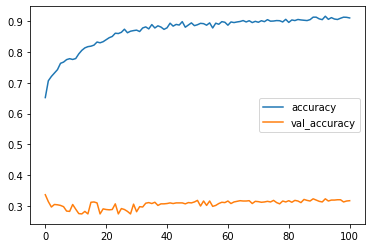

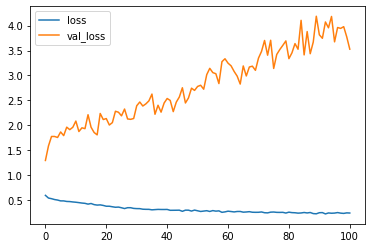

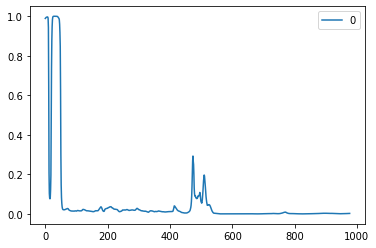

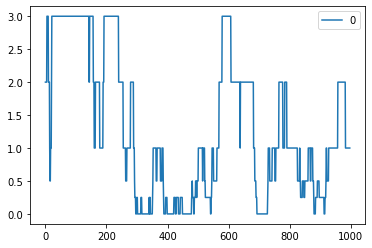

In [11]:
df = pd.read_csv("/content/gdrive/My Drive/AMD.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1w'] = (df['mov5'].shift(-5) - df['mov5'])/df['mov5']
df['2w'] = (df['mov5'].shift(-10) - df['mov5'])/df['mov5']
df['4w'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['6w'] = (df['mov5'].shift(-30) - df['mov5'])/df['mov5']
df['8w'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['10w'] = (df['mov5'].shift(-50) - df['mov5'])/df['mov5']
df['12w'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['18w'] = (df['mov5'].shift(-90) - df['mov5'])/df['mov5']
df['24w'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5']

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df = df.dropna(axis=0)

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1              # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2              # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3              # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

from tensorflow.keras.callbacks import ModelCheckpoint

modelpath = "/content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5"
checkpointer = ModelCheckpoint(filepath = modelpath, monitor = 'val_loss', verbose = 1, save_best_only = True)

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 100)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5")

# 모델 객체 만들고 훈련

r = model.fit([X_train, X_train, X_train], 
          Y_train,
          batch_size = 64,
          epochs = 500,
          validation_data = ([X_test, X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_test,X_test, X_test])).plot()
pd.DataFrame(target[Ntrain:]).plot()

In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/SBUX_rev.2.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = (df['mov5'].shift(-1) - df['mov5'])/df['mov5']
df['1w'] = (df['mov5'].shift(-5) - df['mov5'])/df['mov5']
df['2w'] = (df['mov5'].shift(-10) - df['mov5'])/df['mov5']
df['4w'] = (df['mov5'].shift(-20) - df['mov5'])/df['mov5']
df['6w'] = (df['mov5'].shift(-30) - df['mov5'])/df['mov5']
df['8w'] = (df['mov5'].shift(-40) - df['mov5'])/df['mov5']
df['10w'] = (df['mov5'].shift(-50) - df['mov5'])/df['mov5']
df['12w'] = (df['mov5'].shift(-60) - df['mov5'])/df['mov5']
df['18w'] = (df['mov5'].shift(-90) - df['mov5'])/df['mov5']
df['24w'] = (df['mov5'].shift(-120) - df['mov5'])/df['mov5']
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5']

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df = df.dropna(axis=0)

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1              # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2              # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3              # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

from tensorflow.keras.callbacks import ModelCheckpoint

modelpath = "/content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5"
checkpointer = ModelCheckpoint(filepath = modelpath, monitor = 'val_loss', verbose = 1, save_best_only = True)

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 100)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5")

# 모델 객체 만들고 훈련

r = model.fit([X_train, X_train, X_train], 
          Y_train,
          batch_size = 64,
          epochs = 500,
          validation_data = ([X_test, X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_test,X_test, X_test])).plot()
pd.DataFrame(target[Ntrain:]).plot()
